# Detection of Toxic Comments

Kaggle competition: [Toxic Comment Classification Challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge)

In [105]:
seed = 333

## Import

In [106]:
import csv
from datetime import datetime
import string
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation,GlobalMaxPool1D,Bidirectional
from keras.layers.embeddings import Embedding
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

## Load Data

In [108]:
"""
load the data and separate into user ids, user comments and toxicity labels for each comment
"""
def read_comments(filename = ''):
    comments = []
    labels = []
    ids = []

    with open (filename) as csvDataFile:
        csvReader = csv.reader(csvDataFile)

        header = True
        for row in csvReader:
            if header:
                header = False
                continue
            ids.append(row[0])
            s = row[1].translate(string.punctuation)
            comments.append(s)          
            if len(row) > 2:
                classes = []
                for i in range(2,8):
                    classes.append(row[i])
                labels.append(classes)

    ids = np.asarray(ids)
    X = np.asarray(comments)
    Y = np.asarray(labels, dtype=int)

    return ids, X, Y

In [109]:
"""
separate the two datasets into training and testing
"""

id_train, X_train, Y_train = read_comments('./data/train.csv')
id_test, X_test, _ = read_comments('./data/test.csv')
labels = ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]

max_comment = 0
for i in range(X_train.shape[0]):                               
    l = len(X_train[i].split())
    if max_comment < l:
        max_comment = l
for i in range(X_test.shape[0]):                               
    l = len(X_test[i].split())
    if max_comment < l:
        max_comment = l
num_classes = len(labels)

## Split Data

In [36]:
kfold = KFold(n_splits=5)
# removed the random state as data does not get shuffled 

# folds = list()
# for train_index, dev_index in kfold.split(X_train):
#     folds.append({
#         'train_index' : train_index,
#         'dev_index' : dev_index,     
#     })

## Embed words and comments using GloVe

We first load the GloVe embedding. This will create a map $\text{Gl}$ which assigns a vector in the vector space of embedded words  $\cong \mathbb{R}^{25}$ to each word in the GloVe corpus

In [96]:
"""
A corpus of words is indexed (index of word called using word_to_index and conversely). A word is then embedded as a
vector using word_to_vec
"""


def read_embeddings(glove_file):
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

In [52]:
word_to_index, index_to_word, word_to_vec = read_embeddings('./glove/glove.twitter.27B.25d.txt')
word_to_vec["0.065561"] = [ 0.39605,  -0.96669,   0.23706,  -0.41379,  -0.97006,   0.16601,  -1.292,
 -0.58989,   0.11632,  -1.365,    -0.27939,  -0.57222,  -0.97108,  -0.56319,
 -0.015263, -0.70465,  -0.13867 ,  1.0702 ,  -0.25557  , 0.25122,  -0.87755,
  0.70999 ,  0.9118 ,  -0.30077, 0 ]
"word_to_vec["dog"]

array([ -1.24200000e+00,  -3.59800000e-01,   5.72850000e-01,
         3.66750000e-01,   6.00210000e-01,  -1.88980000e-01,
         1.27290000e+00,  -3.69210000e-01,   8.90800000e-02,
         4.03390000e-01,   2.51300000e-01,  -2.55480000e-01,
        -3.92090000e+00,  -1.11000000e+00,  -2.13080000e-01,
        -2.38460000e-01,   9.53220000e-01,  -5.27500000e-01,
        -7.80490000e-04,  -3.57710000e-01,   5.55820000e-01,
         7.78690000e-01,   4.68740000e-01,  -7.78030000e-01,
         7.83780000e-01])

In [35]:
"""
Split each message into words , check if each word is present in corpus and if the message contains fuck
"""

for r in X_train:
    words = r.split()
    for w in words:
        if w not in word_to_index:
            if 'fuck' in w:
                print(w)



fistfuckee.
fuck.
fuck.++You
motherfucker!!!
++fuck
fuck.
Assfuckers
muthafucker.
""fucking
++Muthafucka
fuck.
dumbfucks.
muthafucka!
mothafucka!
clusterfucked
""clusterfucked
motherfucker.
""fucking
fuck...Before
http://gawker.com/5636765/facebook-ceo-admits-to-calling-users-dumb-fucks+
http://www.theweek.co.uk/technology/14625/are-users-%E2%80%98dumb-fucks%E2%80%99-trusting-data-facebook+
http://tdh.me/zuckerberg-called-early-facebook-users-dumb-fucks-so-what/+
http://anphicle.com/en/they-trust-me-dumb-fucks-facebook-ceo-mark-zuckerberg/+
fucks"".
fucks.++In
Corpsefucking
Corpsefucking
Corpsefucking
Corpsefucking
changes++fuck
motherfucker""
dumass.++fuck
""fucking
fuckkk
""mindfuck""
fuck's
Mindfuck
fuck?
fuckface.
fuck.
fuckin'
motherfucker,
bitch.++fuck
lord/fuck
fuckersItalic
dumbfuck,
fuck,
fuck????
fucking-ass
++fuck
Merchan-fucking-dise
T-fucking-800.
fuck...damn
""fuck""
""fuck,""
""fuck""
""fuck""
""fucking"")
""fuck""
""fuck""
""fuck""
""fuck""
""fuck""
fuck.
'fuck'
""fuck.

Next, use the map $\text{Gl}$ to create an embedding of each comment in the dataspace into $\mathbb{R}^{25}$. This uses a function $\Phi:\mathbb{R}^{25\times n}\longrightarrow \mathbb{R}^{25}$ which associates to $n$ embedded words a single embedded word

In [127]:
def embed_comment(comment,phi):
    """
    convert a comment into a list of words and apply the function
    """
    words = comment.lower().split()
    embedded_comment = phi(words)
    return embedded_comment

As an example of a function, we take the mean of the embedded words in a comment (making sure every word indeed lies in the GloVe corpus)

In [128]:
def avg(comment):
    avg = np.zeros(shape=(len(word_to_vec['apple']), ))
    for w in comment:
        if w in word_to_vec:
            avg += word_to_vec[w]
    avg = avg / len(comment)
    return avg  

Test it on a specific comment:

In [131]:
embed_comment("you are nice",avg)

array([-0.33236   ,  0.04180133, -0.08893267, -0.29773667, -0.34060667,
        0.42482   ,  1.7229    , -0.096961  , -0.93848667,  0.09561933,
       -0.32179667,  0.456702  , -5.20073333, -0.20553333, -0.38219333,
       -0.10963433,  0.25742333, -0.99007333, -0.17248333, -0.21952667,
        0.24352767,  0.196192  , -0.36706667,  0.44628   , -0.41614   ])

In [46]:
def average_comment(comment, word_to_vec):
    """
    Converts a comment into a list of words. 
    Extracts the GloVe representation of each word
    and averages its value into a single vector encoding the meaning of the sentence.
    
    Arguments:
    comment -- string
    word_to_vec_map -- dictionary mapping every word in a vocabulary 
    into its n-dimensional vector representation
    
    Returns:
    avg -- average vector encoding information about the sentence, numpy-array of shape (n,)
    """
    words = comment[0].lower().split()
    avg = np.zeros(shape=(len(word_to_vec['apple']), ))
    for w in words:
        if w in word_to_vec:
            avg += word_to_vec[w]
    avg = avg / len(words)
    return avg

In [130]:
average_comment("you are nice",word_to_vec)

array([ 0.21767 ,  0.19018 , -0.27414 ,  0.69654 ,  0.12748 ,  0.83719 ,
       -1.2804  ,  3.8718  , -0.96223 , -1.1195  ,  0.985   , -2.4167  ,
       -2.9994  ,  0.017624,  1.3301  ,  0.48203 , -0.19386 ,  0.09823 ,
        1.2263  ,  0.80212 ,  0.48846 , -0.98181 ,  0.53096 ,  0.4342  ,
        0.67874 ])

Next, we gather all embedded comments in a single array

In [ ]:
averages = list()
for c in X_train:
    averages.append(average_comment(c, word_to_vec))
averages = np.asarray(averages)

In [98]:
len(Y_train)

106912

## Learning Curves

In [97]:
def learning_curves(model):
    #plot the learning curve for the accuracy
        #plot the accuracy on the training set
        plt.plot(model.history['acc'])
        #plot the accuracy on the dev set
        plt.plot(model.history['val_acc'])
        #describe the labels
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'dev'], loc='upper left')
        plt.show()
    # plot the learning curve for the loss
        #plot the loss on the training set
        plt.plot(model.history['loss'])
        #plot the loss on the dev set
        plt.plot(model.history['val_loss'])
        #describe the labels
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'dev'], loc='upper left')
        plt.show()

## Fit and Train the model

In [81]:
"""
compile a Keras model and fit it according to a certain optimizer, loss, epochs and batch size
"""

def comp_fit(model,optim,loss,epochs,bs):
    model.compile(optimizer=optim, loss=loss, metrics=['accuracy'])
    history=model.fit(X_train, Y_train, validation_data=(X_dev, Y_dev), epochs=epochs, batch_size=bs,  verbose=1)
    return history


## The baseline model

Takes in a 25-dim vector computed as $\frac{1}{n}\sum_{w\in c}\text{Gl}(w) $ where $n$ is the length of the comment $c$ and performs logistical regression

declare the training parameters:

In [82]:
optim = 'adam'
loss = 'binary_crossentropy'
epochs = 4
bs = 4

declare the training and dev-data:

In [83]:
from sklearn.model_selection import train_test_split

In [93]:
labels_train = Y_train
X_train, X_dev, Y_train, Y_dev = train_test_split(averages, labels_train, test_size=0.33, random_state=42)

build, compile and fit the regression model

In [94]:
def baseline_model(num_dim=25, num_labels=6):
    # create model
    model = Sequential()
    model.add(Dense(num_labels, input_shape=(num_dim,), kernel_initializer='normal', activation='sigmoid'))
    history = comp_fit(model,optim,loss,epochs,bs)
    learning_curves(history)
    return baseline_model

Train on 106912 samples, validate on 52659 samples
Epoch 1/4
106912/106912 [==============================] - 77s - loss: 0.1383 - acc: 0.9631 - val_loss: 0.1355 - val_acc: 0.9629
Epoch 2/4
106912/106912 [==============================] - 78s - loss: 0.1335 - acc: 0.9635 - val_loss: 0.1348 - val_acc: 0.9629
Epoch 3/4
106912/106912 [==============================] - 79s - loss: 0.1329 - acc: 0.9635 - val_loss: 0.1348 - val_acc: 0.9630
Epoch 4/4
106912/106912 [==============================] - 79s - loss: 0.1326 - acc: 0.9635 - val_loss: 0.1344 - val_acc: 0.9630


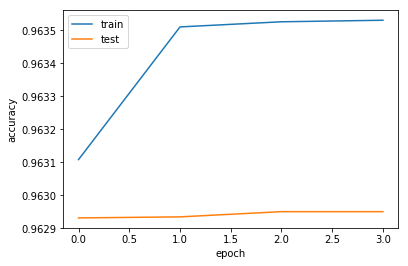

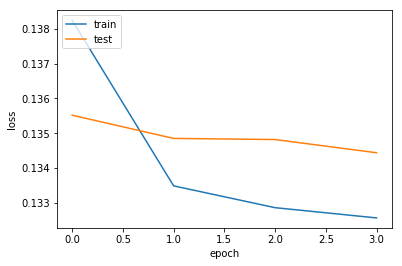

<function __main__.baseline_model>

In [95]:
baseline_model()

## The baseline model

In [37]:
def baseline_model(num_dim=25, num_labels=6):
    # create model
    model = Sequential()
    model.add(Dense(num_labels, input_shape=(num_dim,), kernel_initializer='normal', activation='sigmoid'))
    model.compile(
        loss='binary_crossentropy', 
        #loss=custom_loss,
        optimizer='adam', metrics=['accuracy'])
    return model

In [41]:
model = baseline_model()

In [42]:
model.fit(averages, Y_train, epochs=4, verbose=1)

Epoch 1/4
159571/159571 [==============================] - 14s - loss: 0.1492 - acc: 0.9622    
Epoch 2/4
159571/159571 [==============================] - 15s - loss: 0.1351 - acc: 0.9633    
Epoch 3/4
159571/159571 [==============================] - 13s - loss: 0.1341 - acc: 0.9633    
Epoch 4/4
159571/159571 [==============================] - 13s - loss: 0.1336 - acc: 0.9633    


In [44]:
learning_curves(model)

AttributeError: 'Sequential' object has no attribute 'history'

## Custom Loss

In [20]:
from sklearn.metrics import log_loss
from keras.backend import int_shape
import keras.backend as K
import tensorflow as tf
_EPSILON = K.epsilon()
    
def custom_loss(y_true, y_pred):
    losses = []
    y_pred = K.clip(y_pred, _EPSILON, 1.0-_EPSILON)
    num_classes = int_shape(y_pred)[1]
    for i in range(num_classes):
        losses.append(K.mean(-(
            y_true[:, i]*K.log(y_pred[:, i]) - (1-y_true[:, i])*K.log(1-y_pred[:, i])
        ), axis = -1))
    loss = tf.stack(losses)
    loss = K.mean(loss, axis=-1)
        
    return loss
    #return tf.convert_to_tensor(losses, dtype='float32')

## Cross Validation

In [21]:
np.random.seed(seed)
estimator_baseline = KerasRegressor(build_fn=baseline_model, 
                                    nb_epoch=1, batch_size=5, verbose=1)
results = cross_val_score(estimator_baseline, averages, Y_train, cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Epoch 1/10
127656/127656 [==============================] - 73s - loss: 0.1383 - acc: 0.9631    
Epoch 2/10
127656/127656 [==============================] - 69s - loss: 0.1337 - acc: 0.9635    
Epoch 3/10
127656/127656 [==============================] - 67s - loss: 0.1331 - acc: 0.9635    
Epoch 4/10
127656/127656 [==============================] - 67s - loss: 0.1328 - acc: 0.9635    
Epoch 5/10
127656/127656 [==============================] - 65s - loss: 0.1326 - acc: 0.9635    
Epoch 6/10
127656/127656 [==============================] - 70s - loss: 0.1325 - acc: 0.9635    
Epoch 7/10
127656/127656 [==============================] - 68s - loss: 0.1324 - acc: 0.9635    
Epoch 8/10
127656/127656 [==============================] - 68s - loss: 0.1324 - acc: 0.9635    
Epoch 9/10
127656/127656 [==============================] - 67s - loss: 0.1323 - acc: 0.9635    
Epoch 10/10
127657/127657 [==============================] - 68s - loss: 0.1386 - acc: 0.9631    
Epoch 2/10
127657/127657 [===

KeyboardInterrupt: 

## RNN

In [22]:
def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this. 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    m = X.shape[0]                                   # number of training examples
    X_indices = np.zeros(shape=(m, max_len))
    for i in range(m):                               
        sentence_words = X[i].lower().split()
        if len(sentence_words) > max_len:
            print ("Too many words:", len(sentence_words))
            continue
        j = 0
        for w in sentence_words:
            if w in word_to_index:
                X_indices[i, j] = word_to_index[w]
            else :
                X_indices[i, j] = word_to_index['word']
            j = j + 1
    return X_indices

In [23]:
X_train_indices = sentences_to_indices(X_train, word_to_index, max_comment)
X_test_indices = sentences_to_indices(X_test, word_to_index, max_comment)

In [24]:
def pretrained_embedding_layer(word_to_vec, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 
    
    Arguments:
    word_to_vec -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    # adding 1 to fit Keras embedding (requirement)
    vocab_len = len(word_to_index) + 1                  
    emb_dim = word_to_vec["cucumber"].shape[0]  
    emb_matrix = np.zeros(shape=(vocab_len, emb_dim))
    
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec[word]

    embedding_layer = Embedding(vocab_len, emb_dim, trainable=False)
    embedding_layer.build((None,))
    embedding_layer.set_weights([emb_matrix])
    return embedding_layer

In [25]:
def rnn_model(input_shape, num_classes, word_to_vec, word_to_index):
    """
    Create the model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec -- dictionary mapping every word in a vocabulary into its n-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary 

    Returns:
    model -- a model instance in Keras
    """
    sentence_indices = Input(shape=input_shape, dtype='float32')
    embedding_layer = pretrained_embedding_layer(word_to_vec, word_to_index)
    embeddings = embedding_layer(sentence_indices)   
    
    X = Bidirectional(LSTM(18, return_sequences = False))(embeddings)
    X = Dropout(rate=0.1)(X)
#     X = LSTM(8, return_sequences = False)(X)
#     X = Dropout(rate=0.2)(X)
    X = Dense(units=50, activation='relu')(X)
    X = Dropout(0.1)(X)
    X = Dense(units=num_classes, activation='sigmoid')(X)
    model = Model(inputs = [sentence_indices], outputs = X)
    
    return model

In [26]:
model_RNN = rnn_model((max_comment,), num_classes, word_to_vec, word_to_index)
model_RNN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2321)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 2321, 25)          29837875  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 36)                6336      
_________________________________________________________________
dropout_1 (Dropout)          (None, 36)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)                1850      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 306       
Total para

In [27]:
model_RNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [28]:
model_RNN.fit(X_train_indices, Y_train, epochs = 2, batch_size = 128, shuffle=True, verbose=True)

Epoch 1/2
 63104/159571 [==========>...................] - ETA: 7041s - loss: 0.1488 - acc: 0.9584

KeyboardInterrupt: 

## Testing

In [59]:
import matplotlib.pyplot as plt

def plot_predictions(probabilities, title):
    fig = plt.figure(figsize=(12, 4))
    fig.suptitle(title)
    plt.autoscale(enable=False, axis='y')
    width = 0.85
    ind = np.arange(len(probabilities))
    plt.bar(ind, probabilities, width=width, color='g')
    plt.xticks(ind, labels)
    
def predict(text, model):
    plot_predictions(model.predict(sentences_to_indices(
        np.asarray([text]),word_to_index, max_comment))[0], text)    

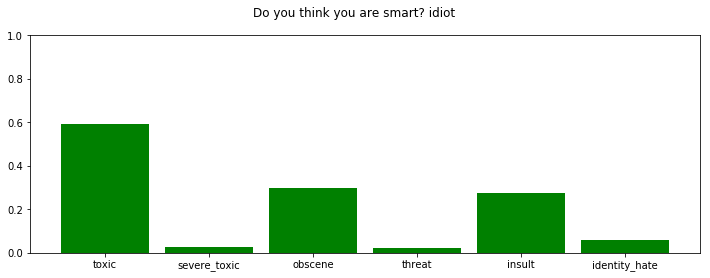

In [60]:
predict("Do you think you are smart? idiot", model_RNN)

[0.1509509  0.00603852 0.07105798 0.0083426  0.06707279 0.00881005]


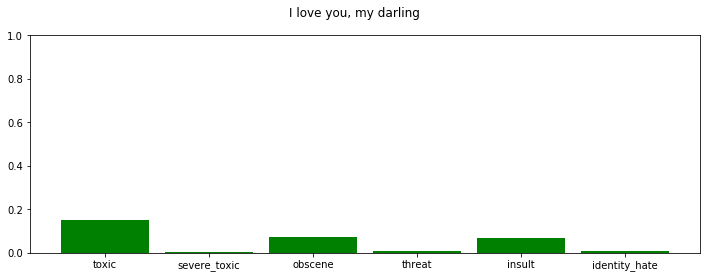

In [56]:
predict("I love you, my darling", model_RNN)

## Submission

In [21]:
y = model_RNN.predict(X_test_indices)

In [22]:
result = pd.concat([
    pd.DataFrame(id_test, columns=['id']), 
    pd.DataFrame(y, columns=labels)], axis=1)
result = result.set_index('id')
result = result.fillna(0.0)
result.to_csv('./result/anton_rnn_{}.csv'.format(datetime.now()), header=True)